In [ ]:
#Mounted to Google Drive
from google.colab import drive
import os
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression


%matplotlib inline

In [ ]:
# load the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PPI/features_training1/features_1_20.csv')

# check the dimension of the dataset
print(data.shape)

# view the first 5 rows of the dataset
data.head()

(13440, 9)


,rmsd_l,rmsd_i,dfnat,dbsa,dnonb_e,dnonb_water,dcom_distance,dhbnum,quality
0,0.524341,0.218659,0.22,-3.861,351.554,-911.7,0.146,-5.0,native
1,0.508332,0.212990,0.25,-2.923,238.509,-1408.8,0.158,-4.0,native
2,0.537800,0.244115,0.14,-3.347,240.279,-2387.5,0.201,-3.0,native
3,0.694089,0.298283,0.17,-4.860,362.270,-2842.3,0.184,-5.0,native
4,0.610487,0.296998,0.16,-5.619,349.431,-2135.9,0.226,-4.0,native


In [ ]:
data['quality'] = data['quality'].map({'native': 1, 'non-native': 0})
data.head()

,rmsd_l,rmsd_i,dfnat,dbsa,dnonb_e,dnonb_water,dcom_distance,dhbnum,quality
0,0.524341,0.218659,0.22,-3.861,351.554,-911.7,0.146,-5.0,1
1,0.508332,0.212990,0.25,-2.923,238.509,-1408.8,0.158,-4.0,1
2,0.537800,0.244115,0.14,-3.347,240.279,-2387.5,0.201,-3.0,1
3,0.694089,0.298283,0.17,-4.860,362.270,-2842.3,0.184,-5.0,1
4,0.610487,0.296998,0.16,-5.619,349.431,-2135.9,0.226,-4.0,1


In [ ]:
X = data.drop('quality', axis=1)
y = data['quality']
print(X.head())

     rmsd_l    rmsd_i  dfnat   dbsa  dnonb_e  dnonb_water  dcom_distance  \
0  0.524341  0.218659   0.22 -3.861  351.554       -911.7          0.146   
1  0.508332  0.212990   0.25 -2.923  238.509      -1408.8          0.158   
2  0.537800  0.244115   0.14 -3.347  240.279      -2387.5          0.201   
3  0.694089  0.298283   0.17 -4.860  362.270      -2842.3          0.184   
4  0.610487  0.296998   0.16 -5.619  349.431      -2135.9          0.226   

   dhbnum  
0    -5.0  
1    -4.0  
2    -3.0  
3    -5.0  
4    -4.0  


In [ ]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [ ]:
X_train.shape, X_test.shape

((10752, 8), (2688, 8))

In [ ]:
# scale the training and test data, initialize a MinMaxScaler object
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(X_train)
Xtest_scaled = scaler.transform(X_test)
Xtrain_scaled

array([[0.04918485, 0.03137249, 0.35211268, ..., 0.65746267, 0.23186683,
        0.30769231],
       [0.04150006, 0.03969497, 0.16901408, ..., 0.54316789, 0.19381688,
        0.42307692],
       [0.03157514, 0.01300768, 0.57746479, ..., 0.57910809, 0.20293302,
        0.5       ],
       ...,
       [0.09153166, 0.01707601, 0.15492958, ..., 0.74852769, 0.32183908,
        0.34615385],
       [0.0533069 , 0.02011719, 0.5915493 , ..., 0.62177034, 0.19678954,
        0.5       ],
       [0.05850623, 0.00535326, 0.53521127, ..., 0.5459043 , 0.23285771,
        0.42307692]])

In [ ]:
Xtest_scaled

array([[0.03494326, 0.02490021, 0.36619718, ..., 0.57024449, 0.21581451,
        0.46153846],
       [0.01056681, 0.01245147, 0.56338028, ..., 0.58052587, 0.19579865,
        0.34615385],
       [0.04730248, 0.06291707, 0.01408451, ..., 0.66490849, 0.18034086,
        0.38461538],
       ...,
       [0.0200631 , 0.0253438 , 0.53521127, ..., 0.63577958, 0.20253666,
        0.53846154],
       [0.02618038, 0.01575285, 0.21126761, ..., 0.54246396, 0.21581451,
        0.15384615],
       [0.0410879 , 0.02621538, 0.1971831 , ..., 0.47390494, 0.20868014,
        0.26923077]])

**1. LOGISTIC REGRESSION**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Define the parameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'penalty': ['l1', 'l2'],               # Norm used in the penalization
    'solver': ['liblinear', 'saga']        # Algorithm to use for optimization
}

# Create LogisticRegression
log_reg = LogisticRegression()

# Create GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best model
best_log_reg = grid_search.best_estimator_

# Make predictions
y_train_pred = best_log_reg.predict(X_train)
y_test_pred = best_log_reg.predict(X_test)

# Training set performance
log_reg_train_accuracy = accuracy_score(y_train, y_train_pred)
log_reg_train_precision = precision_score(y_train, y_train_pred)
log_reg_train_recall = recall_score(y_train, y_train_pred)
log_reg_train_f1 = f1_score(y_train, y_train_pred, average='weighted')
log_reg_train_auc = roc_auc_score(y_train, best_log_reg.predict_proba(X_train)[:, 1])
log_reg_train_mcc = matthews_corrcoef(y_train, y_train_pred)

# Test set performance
log_reg_test_accuracy = accuracy_score(y_test, y_test_pred)
log_reg_test_precision = precision_score(y_test, y_test_pred)
log_reg_test_recall = recall_score(y_test, y_test_pred)
log_reg_test_f1 = f1_score(y_test, y_test_pred, average='weighted')
log_reg_test_auc = roc_auc_score(y_test, best_log_reg.predict_proba(X_test)[:, 1])
log_reg_test_mcc = matthews_corrcoef(y_test, y_test_pred)

# Print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

# Print model performance
print('Model performance for Training set')
print('- Accuracy: %s' % log_reg_train_accuracy)
print('- Precision: %s' % log_reg_train_precision)
print('- Recall: %s' % log_reg_train_recall)
print('- F1 score: %s' % log_reg_train_f1)
print('- AUC: %s' % log_reg_train_auc)
print('- MCC: %s' % log_reg_train_mcc)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % log_reg_test_accuracy)
print('- Precision: %s' % log_reg_test_precision)
print('- Recall: %s' % log_reg_test_recall)
print('- F1 score: %s' % log_reg_test_f1)
print('- AUC: %s' % log_reg_test_auc)
print('- MCC: %s' % log_reg_test_mcc)

Best hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Model performance for Training set
- Accuracy: 0.6546688988095238
- Precision: 0.6434362601345524
- Recall: 0.6938244047619048
- F1 score: 0.6541386402046092
- AUC: 0.711457025437128
- MCC: 0.31029070748227844
----------------------------------
Model performance for Test set
- Accuracy: 0.6421130952380952
- Precision: 0.6297554347826086
- Recall: 0.6897321428571429
- F1 score: 0.6412997159090909
- AUC: 0.7049707252692744
- MCC: 0.2855240337121047


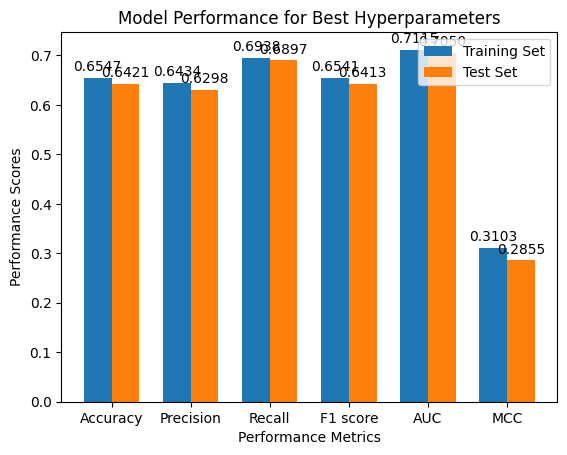

In [ ]:
# Define the performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC', 'MCC']

# Training set performance values for Logistic Regression
train_values = [log_reg_train_accuracy, log_reg_train_precision, log_reg_train_recall, log_reg_train_f1, log_reg_train_auc, log_reg_train_mcc]

# Test set performance values for Logistic Regression
test_values = [log_reg_test_accuracy, log_reg_test_precision, log_reg_test_recall, log_reg_test_f1, log_reg_test_auc, log_reg_test_mcc]

# Create a bar chart
bar_width = 0.35
index = np.arange(len(metrics))

fig, ax = plt.subplots()

bar1 = ax.bar(index, train_values, bar_width, label='Training Set')
bar2 = ax.bar(index + bar_width, test_values, bar_width, label='Test Set')

# Add labels, title, and legend
ax.set_xlabel('Performance Metrics')
ax.set_ylabel('Performance Scores')
ax.set_title('Model Performance for Best Hyperparameters')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

# Display the values on top of the bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.4f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)

plt.show()


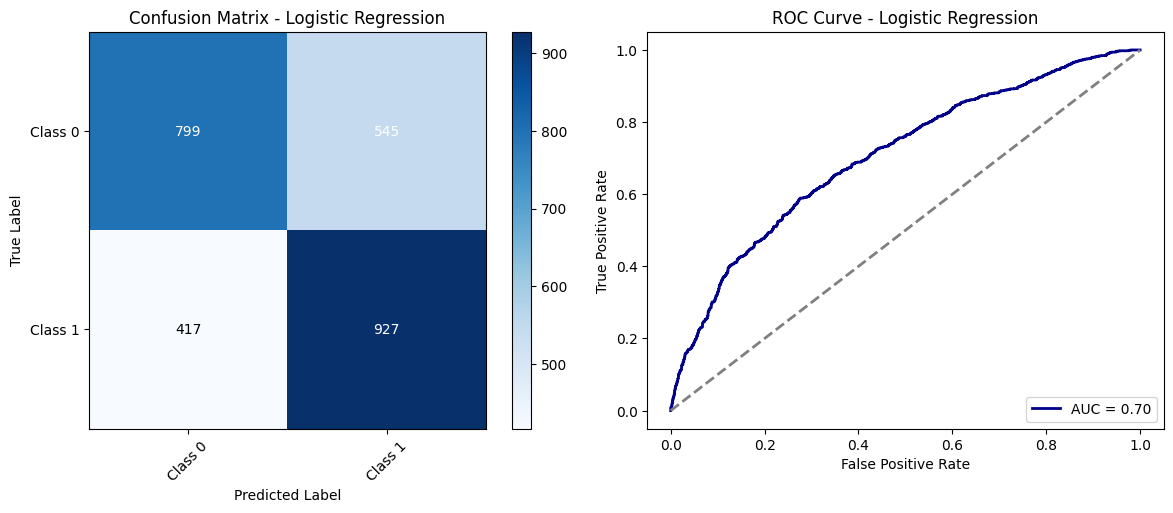

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Function to plot confusion matrix
def plot_confusion_matrix(ax, y_true, y_pred, classes, title='Confusion Matrix - Logistic Regression'):
    cm = confusion_matrix(y_true, y_pred)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    ax.figure.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    # Loop over data dimensions and create text annotations.
    fmt = 'd'  # Format as integer
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

# Function to plot ROC curve
def plot_roc_curve(ax, y_true, y_score, title='ROC Curve - Logistic Regression'):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    area_under_curve = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkblue', lw=2, label=f'AUC = {area_under_curve:.2f}')
    ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc='lower right')

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Confusion Matrix
plot_confusion_matrix(axs[0], y_test, y_test_pred, classes=['Class 0', 'Class 1'], title='Confusion Matrix - Logistic Regression')

# Plot ROC Curve
plot_roc_curve(axs[1], y_test, best_log_reg.predict_proba(X_test)[:, 1], title='ROC Curve - Logistic Regression')

plt.tight_layout()
plt.show()
